In [1]:
import numpy as np
import argparse
import os, time

from pykin.utils import plot_utils as p_utils

from pytamp.benchmark import Rearrange1

from pytamp.action.pick import PickAction
from pytamp.action.rearrangement import RearrangementAction

from pytamp.benchmark.rearrange1 import make_scene
from pytamp.search.mcts_for_rearragement import MCTS_rearrangement
from pykin.utils.kin_utils import ShellColors as sc


def get_parser():
    parser = argparse.ArgumentParser(description="Test Rearragement 1.")
    parser.add_argument("--budgets", metavar="T", type=int, default=100, help="Horizon")
    parser.add_argument("--max_depth", metavar="H", type=int, default=10, help="Max depth")
    parser.add_argument("--seed", metavar="i", type=int, default=8, help="A random seed")
    parser.add_argument(
        "--algo",
        metavar="alg",
        type=str,
        default="bai_perturb",
        choices=["bai_perturb", "bai_ucb", "uct", "random", "greedy"],
        help="Choose one (bai_perturb, bai_ucb, uct)",
    )
    parser.add_argument(
        "--debug_mode", default=False, type=lambda x: (str(x).lower() == "true"), help="Debug mode"
    )
#     parser.add_argument("--box_number", metavar="N", type=int, default=6, help="Box Number(6 or less)")
    try:
        args = parser.parse_args() #call from command line
    except:
        args = parser.parse_args(args=[]) #call from notebook
    return args 

args = get_parser() 

debug_mode = args.debug_mode
budgets = args.budgets
max_depth = args.max_depth
algo = args.algo
seed = args.seed
np.random.seed(seed)

object_names, init_scene, goal_scene = make_scene()
rearrangement1 = Rearrange1('doosan', object_names, init_scene, goal_scene, is_pyplot=False)

final_level_1_values = []
final_level_2_values = []
final_optimal_nodes = []
final_pnp_all_joint_paths = []
final_pick_all_objects = []
final_place_all_object_poses = []

# final_optimal_trees = []
c_list = 10 ** np.linspace(-2, 2.0, 10)


usage: ipykernel_launcher.py [-h] [--budgets T] [--max_depth H] [--seed i]
                             [--algo alg] [--debug_mode DEBUG_MODE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/juju/.local/share/jupyter/runtime/kernel-9e4640b0-4176-4f43-b383-98feeccf7271.json


*********************** Logical States ***********************
OrderedDict([('ben_cube0',
              {'on': Object(name=table, pos=[ 0.9   -0.6    0.043])}),
             ('can0',
              {'on': Object(name=table, pos=[ 0.9   -0.6    0.043])}),
             ('can1',
              {'on': Object(name=table, pos=[ 0.9   -0.6    0.043])}),
             ('milk0',
              {'on': Object(name=table, pos=[ 0.9   -0.6    0.043])}),
             ('cereal0',
              {'on': Object(name=table, pos=[ 0.9   -0.6    0.043])}),
             ('table',
              {'static': True,
               'support': [Object(name=ben_cube0, pos=[ 0.88928902 -0.39350564  0.84779998]),
                           Object(name=can0, pos=[ 0.87577879 -0.10670371  0.83514841]),
                           Object(name=can1, pos=[ 0.90771777 -0.53253218  0.85059666]),
                           Object(name=milk0, pos=[ 0.37113065 -0.3943761   0.83236691]),
                           Object(name=cereal0,

In [2]:
rearrangement1.scene_mngr.heuristic = False
pick = PickAction(rearrangement1.scene_mngr, n_contacts=10, n_directions=14)
rearr = RearrangementAction(rearrangement1.scene_mngr, n_sample=1)
pick.scene_mngr.is_debug_mode = False 
rearr.scene_mngr.is_debug_mode = False

In [3]:
pick_actions = list(pick.get_possible_actions_level_1())


In [4]:
pnp_all_joint_path = []
pick_all_objects = []
place_all_object_poses = []

pnp_path = []
pick_objects = []
place_object_poses = []

success_joint_path = False
cnt = 0

In [5]:
pick_actions[4]

{'type': 'pick',
 'pick_obj_name': 'cereal0',
 'grasp_poses': [{'grasp': array([[ 0.        ,  0.66060833,  0.75073073,  0.68450718],
          [-0.03680585,  0.75022206, -0.66016073,  0.47802727],
          [-0.99932244, -0.02763128,  0.02431425,  0.92033503],
          [ 0.        ,  0.        ,  0.        ,  1.        ]]),
   'pre_grasp': array([[ 0.        ,  0.66060833,  0.75073073,  0.60943411],
          [-0.03680585,  0.75022206, -0.66016073,  0.54404334],
          [-0.99932244, -0.02763128,  0.02431425,  0.9179036 ],
          [ 0.        ,  0.        ,  0.        ,  1.        ]]),
   'post_grasp': array([[ 0.        ,  0.66060833,  0.75073073,  0.68450718],
          [-0.03680585,  0.75022206, -0.66016073,  0.47802727],
          [-0.99932244, -0.02763128,  0.02431425,  1.02033503],
          [ 0.        ,  0.        ,  0.        ,  1.        ]])},
  {'grasp': array([[ 0.17966162,  0.66060833, -0.72891586,  0.99153385],
          [-0.12225046,  0.75022206,  0.64978587,  0.20

# Level 1

In [6]:
for pick_action in pick_actions[4:]:
    for pick_scene in pick.get_possible_transitions(
        pick.scene_mngr.init_scene, action=pick_action
    ):
        print(f"{sc.OKBLUE}calculate pick pose!!!!!{sc.ENDC}")

        rearr_actions = list(rearr.get_possible_actions_level_1(
                                                    pick_scene,
                                                    rearrangement1.init_scene,
                                                    True
        ))
        for rearr_action in rearr_actions:
            for place_scene in rearr.get_possible_transitions(
                scene=pick_scene, action=rearr_action
            ):
                print(f"{sc.COLOR_BROWN}calculate Place pose!!!!{sc.COLOR_BROWN}")
                print(place_scene)
                pick_joint_path = pick.get_possible_joint_path_level_2(
                    scene=pick_scene, grasp_poses=pick_scene.grasp_poses
                )
                if pick_joint_path:
                    place_joint_path = rearr.get_possible_joint_path_level_2(
                        scene=place_scene,
                        release_poses=place_scene.rearr_poses,
                        init_thetas=pick_joint_path[-1][
                            rearr.move_data.MOVE_default_grasp
                        ][-1],
                    )
                    if place_joint_path:
                        success_joint_path = True
                        break
            if success_joint_path:
                break
        if success_joint_path:
            break
    if success_joint_path:
        break
success_joint_path = False


[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


calculate pick pose!!!!!
calculate Place pose!!!!
solve the problem using LM2!! 
Iterators : 12
WorkingTime[inverse_kinematics]: 0.0106 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 6 --> 50
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 4.008
WorkingTime[run]: 3.1991 sec

WorkingTime[run]: 0.0849 sec

WorkingTime[run]: 0.0980 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 5 --> 40
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 3.779
WorkingTime[run]: 3.1864 sec

solve the problem using LM2!! 
Iterators : 8
WorkingTime[inverse_kinematics]: 0.0062 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000003
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 1.928
WorkingTime[run]: 3.0231 sec

WorkingTime[run]: 0.0847 sec

WorkingTime[run]: 0.0996 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20


Cost is 2.266
WorkingTime[run]: 3.1243 sec



## Level 2 from level 1 scene

In [49]:
pnp_path += pick_joint_path + place_joint_path
pick_objects.append(pick_scene.robot.gripper.attached_obj_name)
place_object_poses.append(
    place_scene.objs[place_scene.pick_obj_name].h_mat
)


pnp_all_joint_path.append(pnp_path)
pick_all_objects.append(pick_objects)
place_all_object_poses.append(place_object_poses)


0 scene
100 scene
Animation Finished..
PWD :  /home/juju/pytamp/examples/doosan/action/rearrangement1
Save finished..


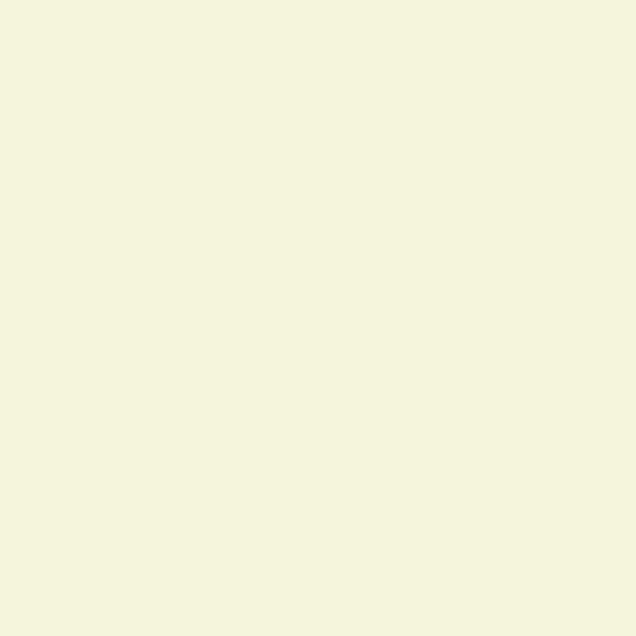

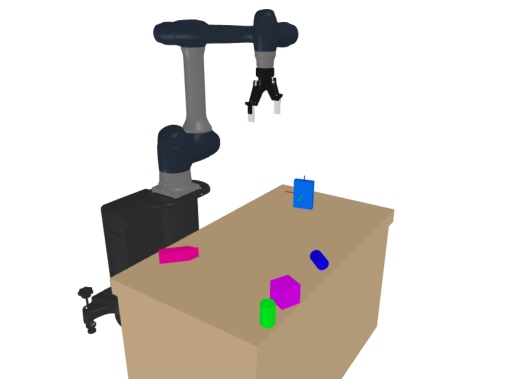

In [50]:
from pykin.utils.kin_utils import apply_robot_to_scene

rearr.scene_mngr.render.render_objects(pick.scene_mngr.scene.objs)
# pick.scene_mngr.render.trimesh_scene = apply_robot_to_scene(
#         trimesh_scene=pick.scene_mngr.render.trimesh_scene, 
#         robot=pick.scene_mngr.scene.robot,
#         geom="visual"
#             )
# pick.scene_mngr.render.set_camera_view()

rearr.simulate_path(
    pnp_all_joint_path,
    pick_all_objects,
    place_all_object_poses,
    is_save=True,
    video_name="pick_rearrangement1_level2_test",
)


# Level 2

pick.scene_mngr.is_debug_mode -> False

In [21]:
place_joint_path = None

for pick_action in pick_actions[1:2]:
    for pick_scene in pick.get_possible_transitions(
        pick.scene_mngr.init_scene, action=pick_action
    ):
        print(f"{sc.OKBLUE}calculate pick pose!!!!!{sc.ENDC}")

        pick_joint_path = pick.get_possible_joint_path_level_2(
            scene=pick_scene, grasp_poses=pick_scene.grasp_poses
        )
        if pick_joint_path:
            rearr_actions = list(rearr.get_possible_actions_level_1(
                                                        pick_scene,
                                                        rearrangement1.init_scene,
                                                        True
            ))
            for rearr_action in rearr_actions:
                for place_scene in rearr.get_possible_transitions(
                    scene=pick_scene, action=rearr_action
                ):
                    print(f"{sc.COLOR_BROWN}calculate Place pose!!!!{sc.COLOR_BROWN}")

                    place_joint_path = rearr.get_possible_joint_path_level_2(
                        scene=place_scene,
                        release_poses=place_scene.rearr_poses,
                        init_thetas=pick_joint_path[-1][
                            rearr.move_data.MOVE_default_grasp
                        ][-1],
                    )
                    
                if place_joint_path:
                    success_joint_path = True
                    pnp_path += pick_joint_path + place_joint_path
                    pick_objects.append(pick_scene.robot.gripper.attached_obj_name)
                    place_object_poses.append(
                        place_scene.objs[place_scene.pick_obj_name].h_mat
                    )
                    print(place_joint_path)
                    break
            if success_joint_path:
                break
        if success_joint_path:
            break
    if success_joint_path:
        break
success_joint_path = False


[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 11
WorkingTime[inverse_kinematics]: 0.0106 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 6 --> 50
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning


Cost is 4.105
WorkingTime[run]: 2.9113 sec

WorkingTime[run]: 0.1044 sec



[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000002
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


WorkingTime[run]: 0.0962 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 6 --> 50
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000003


Cost is 4.235
WorkingTime[run]: 2.9240 sec

can0 Goal pose : [[ 0.37788068 -0.9258543   0.          0.46834276]
 [ 0.9258543   0.37788068  0.         -0.24617063]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 8
WorkingTime[inverse_kinematics]: 0.0073 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 5 --> 40
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000002
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 3.705
WorkingTime[run]: 2.8714 sec

WorkingTime[run]: 0.0904 sec

WorkingTime[run]: 0.0918 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 6 --> 50
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001


Cost is 3.617
WorkingTime[run]: 2.9097 sec

can0 Goal pose : [[-0.67874763 -0.7343716   0.          0.53709336]
 [ 0.7343716  -0.67874763  0.         -0.55775419]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 7
WorkingTime[inverse_kinematics]: 0.0070 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000004
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning


Cost is 2.714
WorkingTime[run]: 3.0068 sec

WorkingTime[run]: 0.1034 sec



[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000004
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


WorkingTime[run]: 0.1109 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001


Cost is 2.495
WorkingTime[run]: 2.9278 sec

can0 Goal pose : [[-0.86661046 -0.49898527  0.          0.4850414 ]
 [ 0.49898527 -0.86661046  0.          0.05817255]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 5
WorkingTime[inverse_kinematics]: 0.0054 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 1.268
WorkingTime[run]: 2.8175 sec

WorkingTime[run]: 0.0877 sec

WorkingTime[run]: 0.0923 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 1.257
WorkingTime[run]: 2.9989 sec

can0 Goal pose : [[ 0.88153778  0.47211348  0.          0.89896439]
 [-0.47211348  0.88153778  0.         -0.43116068]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 6
WorkingTime[inverse_kinematics]: 0.0055 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 2 --> 10
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001


Cost is 0.961
WorkingTime[run]: 2.9836 sec

WorkingTime[run]: 0.0914 sec



[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


WorkingTime[run]: 0.0970 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20


Cost is 0.939
WorkingTime[run]: 3.0390 sec

can0 Goal pose : [[ 0.98719597 -0.15951215  0.          0.87464966]
 [ 0.15951215  0.98719597  0.         -0.5565598 ]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!


[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


solve the problem using LM2!! 
Iterators : 7
WorkingTime[inverse_kinematics]: 0.0057 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001


Cost is 1.284
WorkingTime[run]: 2.9128 sec

WorkingTime[run]: 0.0909 sec



[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


WorkingTime[run]: 0.0952 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 2 --> 10
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 1.12
WorkingTime[run]: 3.1883 sec

can0 Goal pose : [[-0.8135286  -0.5815249   0.          0.82987541]
 [ 0.5815249  -0.8135286   0.          0.22382549]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 11
WorkingTime[inverse_kinematics]: 0.0101 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 6 --> 50
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000002


Cost is 4.057
WorkingTime[run]: 3.0910 sec

WorkingTime[run]: 0.0901 sec



[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


WorkingTime[run]: 0.0975 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 5 --> 40
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 3.937
WorkingTime[run]: 3.0574 sec

can0 Goal pose : [[ 0.3529355   0.93564765  0.          0.85159973]
 [-0.93564765  0.3529355   0.          0.41231677]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 8
WorkingTime[inverse_kinematics]: 0.0085 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 3.281
WorkingTime[run]: 3.0640 sec

WorkingTime[run]: 0.0908 sec

WorkingTime[run]: 0.0941 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 2.985
WorkingTime[run]: 3.0187 sec

can0 Goal pose : [[ 0.9043263  -0.42684182  0.          0.59501398]
 [ 0.42684182  0.9043263   0.          0.22244959]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 7
WorkingTime[inverse_kinematics]: 0.0068 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 5 --> 40
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 2.86
WorkingTime[run]: 2.9606 sec

WorkingTime[run]: 0.0834 sec

WorkingTime[run]: 0.0907 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001


Cost is 2.99
WorkingTime[run]: 3.0370 sec

can0 Goal pose : [[ 0.40541896 -0.91413099  0.          0.56849055]
 [ 0.91413099  0.40541896  0.          0.60534905]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 6
WorkingTime[inverse_kinematics]: 0.0073 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 2.586
WorkingTime[run]: 2.8973 sec

WorkingTime[run]: 0.0860 sec

WorkingTime[run]: 0.0900 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 2.606
WorkingTime[run]: 3.1393 sec

can0 Goal pose : [[ 0.76219764 -0.64734439  0.          0.81656571]
 [ 0.64734439  0.76219764  0.          0.44991536]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 7
WorkingTime[inverse_kinematics]: 0.0072 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000002
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning


Cost is 2.086
WorkingTime[run]: 3.1018 sec

WorkingTime[run]: 0.1077 sec



[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000004
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


WorkingTime[run]: 0.0959 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 5 --> 40
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 2.094
WorkingTime[run]: 3.0871 sec

can0 Goal pose : [[ 0.89336834  0.44932506  0.          0.60043672]
 [-0.44932506  0.89336834  0.          0.58184528]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 7
WorkingTime[inverse_kinematics]: 0.0085 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000002
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 2.125
WorkingTime[run]: 2.9178 sec

WorkingTime[run]: 0.0905 sec

WorkingTime[run]: 0.0920 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints


Cost is 2.183
WorkingTime[run]: 3.1437 sec

can0 Goal pose : [[ 0.81596901  0.57809565  0.          0.51612678]
 [-0.57809565  0.81596901  0.          0.15382639]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 10
WorkingTime[inverse_kinematics]: 0.0111 sec

{('link5', 'table'), ('link6', 'table'), ('link4', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997

[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000002
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has

{('link5', 'table'), ('link6', 'table'), ('link4', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[-1.56345249e-08  8.98944969e-01  4.38061574e-01  4.65644738e-01]
 [-2.81929797e-03  4.38059833e-01 -8.98941397e-01  1.09799355e-01]
 [-9.99996026e-01 -1.23504016e-03  2.53438688e-03  8.45882167e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
***************************************************************

******************** Robot Collision Info *

[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has

Iterators : 16
WorkingTime[inverse_kinematics]: 0.0173 sec

{('link5', 'table'), ('link6', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[-6.57034427e-11  8.98944997e-01  4.38061516e-01  4.65644751e-01]
 [-2.81930156e-03  4.38059775e-01 -8.98941425e-01  1.09799361e-01]
 [-9.99996026e-01 -1.23502757e-03  2.53439701e-03  8.45882164e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
***************************************************************

***

[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has

Iterators : 17
WorkingTime[inverse_kinematics]: 0.0179 sec

{('link5', 'table'), ('link6', 'table'), ('link4', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[-9.17028592e-09  8.98945000e-01  4.38061510e-01  4.65644752e-01]
 [-2.81928506e-03  4.38059770e-01 -8.98941427e-01  1.09799363e-01]
 [-9.99996026e-01 -1.23502851e-03  2.53437819e-03  8.45882168e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
************************************************

[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000002
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


{('link5', 'table'), ('link6', 'table'), ('link4', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[-5.27079048e-08  8.98945007e-01  4.38061495e-01  4.65644745e-01]
 [-2.81921245e-03  4.38059755e-01 -8.98941435e-01  1.09799370e-01]
 [-9.99996026e-01 -1.23503580e-03  2.53429386e-03  8.45882183e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
***************************************************************

******************** Robot Collision Info *

[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints


*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[-1.98401834e-08  8.98944992e-01  4.38061527e-01  4.65644747e-01]
 [-2.81925974e-03  4.38059786e-01 -8.98941419e-01  1.09799359e-01]
 [-9.99996026e-01 -1.23502706e-03  2.53435073e-03  8.45882175e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
***************************************************************

******************** Robot Collision Info ********************
base_0 [0.    0.    0.913]
doosan_pedesta

[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints


Iterators : 19
WorkingTime[inverse_kinematics]: 0.0248 sec

{('link5', 'table'), ('link6', 'table'), ('link4', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[-1.22930220e-08  8.98945019e-01  4.38061472e-01  4.65644752e-01]
 [-2.81928732e-03  4.38059731e-01 -8.98941446e-01  1.09799373e-01]
 [-9.99996026e-01 -1.23503220e-03  2.53437890e-03  8.45882165e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
************************************************

[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000002
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000003
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000003
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000002
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has

Iterators : 18
WorkingTime[inverse_kinematics]: 0.0223 sec

{('link5', 'table'), ('link6', 'table'), ('link4', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[ 1.08296576e-08  8.98944993e-01  4.38061525e-01  4.65644750e-01]
 [-2.81930081e-03  4.38059784e-01 -8.98941420e-01  1.09799361e-01]
 [-9.99996026e-01 -1.23501748e-03  2.53440109e-03  8.45882164e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
************************************************

[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 9
WorkingTime[inverse_kinematics]: 0.0119 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 1.852
WorkingTime[run]: 2.9539 sec

WorkingTime[run]: 0.0911 sec

WorkingTime[run]: 0.0934 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 1.564
WorkingTime[run]: 3.2639 sec

can0 Goal pose : [[ 0.78057059  0.62506764  0.          0.35192099]
 [-0.62506764  0.78057059  0.         -0.05210512]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 7
WorkingTime[inverse_kinematics]: 0.0067 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 1.298
WorkingTime[run]: 3.2019 sec

WorkingTime[run]: 0.0869 sec

WorkingTime[run]: 0.0917 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 2 --> 10
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 1.16
WorkingTime[run]: 3.1873 sec

can0 Goal pose : [[ 0.00137144 -0.99999906  0.          0.31287679]
 [ 0.99999906  0.00137144  0.         -0.05659106]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 6
WorkingTime[inverse_kinematics]: 0.0061 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 2 --> 10
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning


Cost is 1.031
WorkingTime[run]: 3.1108 sec

WorkingTime[run]: 0.0873 sec



[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


WorkingTime[run]: 0.1068 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 2 --> 10
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001


Cost is 1.018
WorkingTime[run]: 3.2194 sec

can0 Goal pose : [[ 0.93315503 -0.35947419  0.          0.83350933]
 [ 0.35947419  0.93315503  0.         -0.46693436]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 5
WorkingTime[inverse_kinematics]: 0.0050 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 1.41
WorkingTime[run]: 3.0356 sec

WorkingTime[run]: 0.0885 sec

WorkingTime[run]: 0.0902 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 3 --> 20
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 1.399
WorkingTime[run]: 3.1821 sec

can0 Goal pose : [[-0.82445515 -0.56592729  0.          0.3208812 ]
 [ 0.56592729 -0.82445515  0.          0.05708996]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 7
WorkingTime[inverse_kinematics]: 0.0091 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000002
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning


Cost is 2.696
WorkingTime[run]: 3.0238 sec

WorkingTime[run]: 0.0947 sec



[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000003
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


WorkingTime[run]: 0.0946 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 4 --> 30
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000


Cost is 2.543
WorkingTime[run]: 2.9997 sec

can0 Goal pose : [[ 0.75550405  0.65514398  0.          0.39518289]
 [-0.65514398  0.75550405  0.          0.2115413 ]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 8
WorkingTime[inverse_kinematics]: 0.0079 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 5 --> 40
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000001
[INFO] [Cartesian Planner]: Start to compute Cartesian Planning
[INFO] [Cartesian Planner]: Generate Path Successfully!! Error is 0.000002
[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Cost is 3.583
WorkingTime[run]: 2.8966 sec

WorkingTime[run]: 0.0886 sec

WorkingTime[run]: 0.0970 sec



[INFO] [RRT Star Planner]: Generate Path Successfully!!
[INFO] [RRT Star Planner]: Path length 5 --> 40


Cost is 3.453
WorkingTime[run]: 2.9215 sec



[INFO] [RRT Star Planner]: Start to compute RRT-star Planning
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints


can0 Goal pose : [[ 0.55924815 -0.8290003   0.          0.51870309]
 [ 0.8290003   0.55924815  0.          0.43080718]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
can0 Goal pose : [[-0.51478001 -0.85732231  0.          0.6488757 ]
 [ 0.85732231 -0.51478001  0.         -0.19734579]
 [ 0.          0.          1.          0.85059666]
 [ 0.          0.          0.          1.        ]]
calculate pick pose!!!!!
solve the problem using LM2!! 
Iterators : 10
WorkingTime[inverse_kinematics]: 0.0086 sec

{('link5', 'table'), ('link6', 'table'), ('link4', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=mil

[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has

Iterators : 20
WorkingTime[inverse_kinematics]: 0.0195 sec

solve the problem using LM2!! 
Iterators : 12
WorkingTime[inverse_kinematics]: 0.0115 sec

{('link5', 'table'), ('link6', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[-2.35103587e-09  8.98944972e-01  4.38061569e-01  4.65644741e-01]
 [-2.81930526e-03  4.38059828e-01 -8.98941399e-01  1.09799351e-01]
 [-9.99996026e-01 -1.23503140e-03  2.53439926e-03  8.45882164e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000

[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000002
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision 

*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[-2.05211445e-08  8.98945010e-01  4.38061490e-01  4.65644751e-01]
 [-2.81927949e-03  4.38059749e-01 -8.98941438e-01  1.09799368e-01]
 [-9.99996026e-01 -1.23503622e-03  2.53436824e-03  8.45882170e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
***************************************************************

******************** Robot Collision Info ********************
base_0 [0.    0.    0.913]
doosan_pedesta

[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints


Iterators : 11
WorkingTime[inverse_kinematics]: 0.0123 sec

{('link5', 'table'), ('link6', 'table'), ('link4', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[-4.27577390e-09  8.98945000e-01  4.38061510e-01  4.65644752e-01]
 [-2.81929220e-03  4.38059769e-01 -8.98941428e-01  1.09799362e-01]
 [-9.99996026e-01 -1.23502724e-03  2.53438675e-03  8.45882167e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
************************************************

[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has

Iterators : 13
WorkingTime[inverse_kinematics]: 0.0143 sec

{('link5', 'table'), ('link6', 'table'), ('link4', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[ 7.85543713e-09  8.98944976e-01  4.38061559e-01  4.65644739e-01]
 [-2.81931459e-03  4.38059818e-01 -8.98941404e-01  1.09799357e-01]
 [-9.99996026e-01 -1.23502628e-03  2.53441213e-03  8.45882163e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
************************************************

[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000002
[WARNING] [RRT Star Planner]: Occur Collision 

*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[ 5.98226019e-09  8.98944994e-01  4.38061523e-01  4.65644748e-01]
 [-2.81929207e-03  4.38059782e-01 -8.98941421e-01  1.09799361e-01]
 [-9.99996026e-01 -1.23501800e-03  2.53439111e-03  8.45882167e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
***************************************************************

******************** Robot Collision Info ********************
base_0 [0.    0.    0.913]
doosan_pedesta

[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000001
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[INFO] [RRT Star Planner]: The joint limit has been successfully checked. Pose error is 0.000000
[WARNING] [RRT Star Planner]: Occur Collision for goal joints
[ERROR] [RRT Star Planner]: Not found IK solution


Iterators : 13
WorkingTime[inverse_kinematics]: 0.0136 sec

{('link5', 'table'), ('link6', 'table'), ('link4', 'table')}
*********************** Scene ***********************
{'ben_cube0': Object(name=ben_cube0, pos=[ 0.84272388 -0.22599388  0.84779998]),
 'can0': Object(name=can0, pos=[ 0.59376204 -0.15476944  0.83517596]),
 'can1': Object(name=can1, pos=[ 0.38362517 -0.27969929  0.85059666]),
 'cereal0': Object(name=cereal0, pos=[ 0.85308839 -0.07997392  0.82529568]),
 'milk0': Object(name=milk0, pos=[0.85844117 0.33893887 0.83236691]),
 'table': Object(name=table, pos=[ 0.9   -0.6    0.043])}
doosan Transform(pos=[0.    0.    0.913], rot=[1. 0. 0. 0.])
robotiq140_gripper [[-1.11645501e-07  8.98944888e-01  4.38061740e-01  4.65644648e-01]
 [-2.81884223e-03  4.38059999e-01 -8.98941317e-01  1.09799332e-01]
 [-9.99996027e-01 -1.23492730e-03  2.53393491e-03  8.45882277e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
************************************************

In [ ]:
place_joint_path = None

for pick_action in pick_actions[1:2]:
    for pick_scene in pick.get_possible_transitions(
        pick.scene_mngr.init_scene, action=pick_action
    ):
        print(f"{sc.OKBLUE}calculate pick pose!!!!!{sc.ENDC}")

        pick_joint_path = pick.get_possible_joint_path_level_2(
            scene=pick_scene, grasp_poses=pick_scene.grasp_poses
        )
        if pick_joint_path:
            rearr_actions = list(rearr.get_possible_actions_level_1(
                                                        pick_scene,
                                                        rearrangement1.init_scene,
                                                        True
            ))
            for rearr_action in rearr_actions:
                for place_scene in rearr.get_possible_transitions(
                    scene=pick_scene, action=rearr_action
                ):
                    print(f"{sc.COLOR_BROWN}calculate Place pose!!!!{sc.COLOR_BROWN}")

                    place_joint_path = rearr.get_possible_joint_path_level_2(
                        scene=place_scene,
                        release_poses=place_scene.rearr_poses,
                        init_thetas=pick_joint_path[-1][
                            rearr.move_data.MOVE_default_grasp
                        ][-1],
                    )
                    
                if place_joint_path:
                    success_joint_path = True
                    pnp_path += pick_joint_path + place_joint_path
                    pick_objects.append(pick_scene.robot.gripper.attached_obj_name)
                    place_object_poses.append(
                        place_scene.objs[place_scene.pick_obj_name].h_mat
                    )
                    print(place_joint_path)
                    break
            if success_joint_path:
                break
        if success_joint_path:
            break
    if success_joint_path:
        break
success_joint_path = False


In [6]:
pnp_all_joint_path.append(pnp_path)
pick_all_objects.append(pick_objects)
place_all_object_poses.append(place_object_poses)


0 scene
100 scene
200 scene
Animation Finished..
PWD :  /home/juju/pytamp/examples/doosan/action/rearrangement1
Save finished..


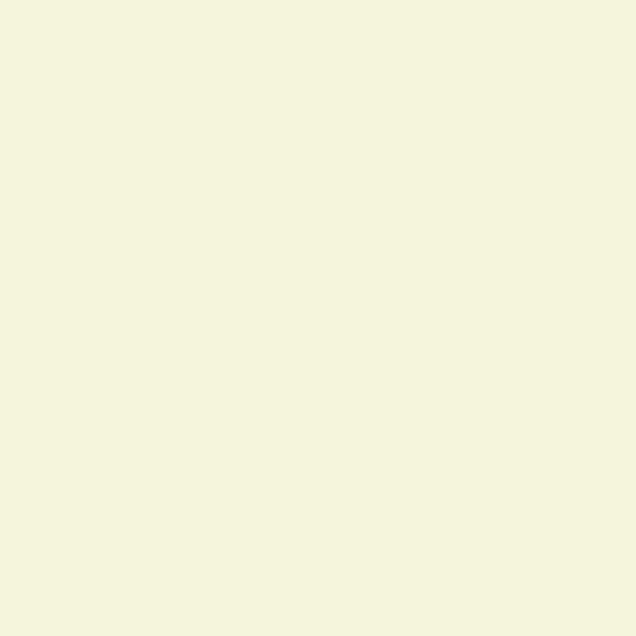

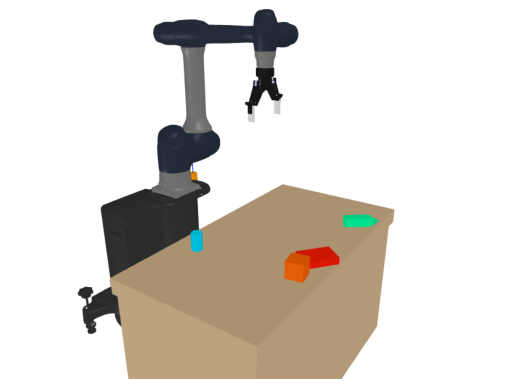

In [7]:
from pykin.utils.kin_utils import apply_robot_to_scene

rearr.scene_mngr.render.render_objects(pick.scene_mngr.scene.objs)
# pick.scene_mngr.render.trimesh_scene = apply_robot_to_scene(
#         trimesh_scene=pick.scene_mngr.render.trimesh_scene, 
#         robot=pick.scene_mngr.scene.robot,
#         geom="visual"
#             )
# pick.scene_mngr.render.set_camera_view()

rearr.simulate_path(
    pnp_all_joint_path,
    pick_all_objects,
    place_all_object_poses,
    is_save=True,
    video_name="pick_rearrangement1_level2_test",
)


In [32]:
rearr_action

{'type': 'rearr',
 'rearr_obj_name': 'can0',
 'place_obj_name': 'table',
 'rearr_poses': [({'release': array([[ 0.62891905,  0.06703063, -0.77457584, -0.09051109],
           [ 0.77714013, -0.08325356,  0.62379649,  0.2587295 ],
           [-0.02267273, -0.99427146, -0.10445195,  0.82823812],
           [ 0.        ,  0.        ,  0.        ,  1.        ]]),
    'pre_release': array([[ 0.62891905,  0.06703063, -0.77457584, -0.09051109],
           [ 0.77714013, -0.08325356,  0.62379649,  0.2587295 ],
           [-0.02267273, -0.99427146, -0.10445195,  0.92823812],
           [ 0.        ,  0.        ,  0.        ,  1.        ]]),
    'post_release': array([[ 0.62891905,  0.06703063, -0.77457584, -0.01305351],
           [ 0.77714013, -0.08325356,  0.62379649,  0.19634985],
           [-0.02267273, -0.99427146, -0.10445195,  0.83868332],
           [ 0.        ,  0.        ,  0.        ,  1.        ]])},
   {'table': array([[-0.34271637,  0.93916964,  0.02249154,  0.50462525],
         

In [31]:
place_scene.rearr_poses

{'release': array([[ 0.62891905,  0.06703063, -0.77457584, -0.09051109],
        [ 0.77714013, -0.08325356,  0.62379649,  0.2587295 ],
        [-0.02267273, -0.99427146, -0.10445195,  0.82823812],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'pre_release': array([[ 0.62891905,  0.06703063, -0.77457584, -0.09051109],
        [ 0.77714013, -0.08325356,  0.62379649,  0.2587295 ],
        [-0.02267273, -0.99427146, -0.10445195,  0.92823812],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'post_release': array([[ 0.62891905,  0.06703063, -0.77457584, -0.01305351],
        [ 0.77714013, -0.08325356,  0.62379649,  0.19634985],
        [-0.02267273, -0.99427146, -0.10445195,  0.83868332],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])}

In [22]:
for pnp_joint_path in pnp_all_joint_path[0]:
    for _, (task, joint_path) in enumerate(pnp_joint_path.items()):
        print(_)

0
1
2
3
0
1
2
3


In [13]:
pla

[OrderedDict([('pre_grasp',
               [array([ 0.00172425,  0.0094176 ,  1.57071799, -0.01332748,  1.56794307,
                        0.01994307]),
                array([ 0.00344851,  0.0188352 ,  1.57063966, -0.02665496,  1.56508981,
                        0.03988613]),
                array([ 0.00517276,  0.0282528 ,  1.57056132, -0.03998243,  1.56223655,
                        0.0598292 ]),
                array([ 0.00689701,  0.0376704 ,  1.57048299, -0.05330991,  1.55938329,
                        0.07977227]),
                array([ 0.00862127,  0.047088  ,  1.57040465, -0.06663739,  1.55653004,
                        0.09971534]),
                array([ 0.01034552,  0.0565056 ,  1.57032632, -0.07996487,  1.55367678,
                        0.1196584 ]),
                array([ 0.01206977,  0.0659232 ,  1.57024799, -0.09329235,  1.55082352,
                        0.13960147]),
                array([ 0.01379403,  0.07534081,  1.57016965, -0.10661983,  1.54797026,
  